In [3]:
import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.chdir('C:/Users/Darui Yen/OneDrive/桌面/data_after_mid')
os.getcwd()

'C:\\Users\\Darui Yen\\OneDrive\\桌面\\data_after_mid'

### Preprocessing and combining 5 raw dataframe 

In [40]:
def array_f(array_repair):

    ## reorder cols
    cols = array_repair.columns.tolist() #store colnames
    cols = cols[3:4]+cols[1:3] #select id, tool_id(2), dft_mode(7)
    array_repair=array_repair[cols] #discard chip_id, rp_end_time

    ## dummy tool & dft (同一個 ID 中只要有用到就是1 沒有就是0)
    array_repair_dummy = pd.get_dummies(array_repair, columns = ['tool_id', 'dft_mode'])
    array_repair_dummy = array_repair_dummy.groupby(['id']).max().reset_index() #order by id
    
    return array_repair_dummy


def cell_test_f(cell_test):
    
    ## delete the tft_chip_id
    cols = cell_test.columns.tolist()
    cols = cols[-1:] + cols[1:3] 
    cell_test = cell_test[cols] # select id, test_user(1) and grade(7)

    ## dummy test_user & grade
    cell_test_dummy = pd.get_dummies(cell_test, columns = ['test_user', 'grade'])
    cell_test_dummy = cell_test_dummy.groupby(['id']).max().reset_index()
    
    return cell_test_dummy


def cell_repair_f(cell_repair):
    
    # delete the tft_chip_id and reorder
    cell_repair = cell_repair.iloc[:,2:] # discard tft_chip_id & product_code
    cols = cell_repair.columns.tolist()
    cols = cols[-1:] + cols[0:-2] # discard rework_time
    cell_repair = cell_repair[cols] # select id, eqp_id(2) and test_defect_code_desc(33)

    ## dummy eqp_id and test_defect_code_desc
    cell_repair_dummy = pd.get_dummies(cell_repair, columns = ['eqp_id', 'test_defect_code_desc'])
    cell_repair_dummy = cell_repair_dummy.groupby(['id']).max().reset_index()

    return cell_repair_dummy


def risk_db_f(risk_db):
    
    cols = risk_db.columns.tolist()
    cols = cols[-1:] + cols[-2:-1] + cols[0:2] # only reorder
    risk_db = risk_db[cols] # select id, lot_no, event_name(15) and process_stage(4)

    ## dummy stage_event
    risk_db['Stage_Event'] = risk_db['process_stage'].str.cat(risk_db[['event_name']], sep=' - ') # combine two variable
    risk_db = risk_db[['id', 'Stage_Event']] # only keep id and stage_event(16)
    risk_dummy = pd.get_dummies(risk_db, columns = ['Stage_Event'])
    risk_dummy = risk_dummy.groupby(['id']).max().reset_index()
    
    return risk_dummy


def module_f(Module):
    
    cols = Module.columns.tolist()
    cols = cols[2:5]+cols[1:2] # discard lot_no & cell_chip_id
    Module = Module[cols] # select shift_date, id, model_no(17) & GB

    ## dummy model_no
    Module_dummy = pd.get_dummies(Module, columns = ['model_no'])
    Module_dummy = Module_dummy.groupby(['id']).max().reset_index() #take a long while

    ## reorder
    cols = Module_dummy.columns.tolist()
    cols = cols[3:] + cols[0:3]
    Module_dummy = Module_dummy[cols]
   
    return Module_dummy


def runhist_array_f(runhist_array, id_mapping, combine = False):
    
    new_array = runhist_array.merge(id_mapping, on = 'sheet_id', how = 'left') # all sheet_id in runhist_array are kept
    col = new_array.columns.tolist()
    col = col[5:6] + col[1:4] # discard lot_no
    new_array = new_array[col]
    new_array['new_eqp'] = [x.split('_')[0] for x in new_array.eqp_id_info]
    new_array = new_array.drop(columns = ['create_time', 'eqp_id_info'])
    
    if combine == False:
        array_dummy = pd.get_dummies(new_array, columns = ['new_eqp', 'op_id_info']) # eqp_id_info(348/57), op_id_info(54)
        array_dummy = array_dummy.groupby(['id']).max().reset_index()
    
    elif combine == True:
        new_array['op_eqp'] = new_array.op_id_info + '_' + new_array.new_eqp
        pair_array = new_array.drop(columns = ['op_id_info', 'new_eqp'])
        array_dummy = pd.get_dummies(pair_array, columns = ['op_eqp'])
        array_dummy = array_dummy.groupby(['id']).max().reset_index()
    
    return array_dummy 


def runhist_cell_f(runhist_cell, id_mapping):
    
    new_cell = runhist_cell.merge(id_mapping.iloc[:,1:], on = 'sheet_id', how = 'left') # combine only id
    col = new_cell.columns.tolist()
    col = col[4:5] + col[1:3] # discard sheet_id, create_time
    new_cell = new_cell[col]

    cell_dummy = pd.get_dummies(new_cell, columns = ['eqp_id_info', 'op_id_info'])
    cell_dummy = cell_dummy.groupby(['id']).max().reset_index()
    
    return cell_dummy


def DataSet_Sorted(array_repair, cell_test, cell_repair, risk_db, Module, id_mapping, runhist_array, runhist_cell):
    
    #global DataSet
    pd.options.mode.chained_assignment = None
    
    cell_test_dummy = cell_test_f(cell_test)
    cell_repair_dummy = cell_repair_f(cell_repair)
    risk_dummy = risk_db_f(risk_db)
    array_repair_dummy = array_f(array_repair)
    Module_dummy = module_f(Module)
    runhist_array_dummy = runhist_array_f(runhist_array, id_mapping)

    #merge data
    CTC = cell_test_dummy.merge(cell_repair_dummy, how = 'outer', on = 'id')
    CTCR = CTC.merge(risk_dummy, how = 'outer',on = 'id')
    CTCRA = CTCR.merge(array_repair_dummy, how = 'inner',on = 'id')
    CTCRAM = CTCRA.merge(Module_dummy, how = 'inner', on = 'id')
    CTCRAMA = CTCRAM.merge(runhist_array, how = 'left', on = 'id')
    DataSet = CTCRAMA.merge(runhist_cell, how = 'left', on = 'id').fillna(0)
    
    #drop not unique columns
    cols = DataSet.columns[DataSet.nunique() == 1]
    DataSet = DataSet.drop(cols, axis = 1)
    
    return DataSet

### Dividing train & test data (by date)

In [5]:
def Train_Test(DataSet, y_1 = 2021, m_1 = 1, d_1 = 31, y_2 = 2021, m_2 = 3, d_2 = 31):
    
    data = DataSet.copy()
    
    date = data['shift_date'].str.split("/",expand = True) # divide day, month and year
    date = date.astype(int)
    date.columns = ['month', 'day', 'year']
    DataSet_split = pd.concat([data,date], axis = 1) #combine with original dataframe
    DataSet_split = DataSet_split.drop('shift_date', axis = 1)  
    DataSet_split = DataSet_split.sort_values(by = ['year', 'month', 'day'])
    DataSet_split = DataSet_split.reset_index(drop = True)
    count_1 = DataSet_split[(DataSet_split.year==y_1)&(DataSet_split.month==m_1)&(DataSet_split.day<=d_1)].tail(1).index.item()
    count_2 = DataSet_split[(DataSet_split.year==y_2)&(DataSet_split.month==m_2)&(DataSet_split.day<=d_2)].tail(1).index.item()
    # search for counts of target date interval
    TrainingSet_0 = DataSet_split.iloc[:count_1+1, :-3]
    TestingSet_0 = DataSet_split.iloc[count_1+1:count_2+1, :-3]
    
    return TrainingSet_0, TestingSet_0, DataSet_split

### Viewing bad data
1. number of bad types, mean of each type, data counts in each type (in 'Bad_Types')
2. record all variable-combination of bad types (in 'Bad')
3. print out the id of all bad types in each month 

In [6]:
def Balance_Ratio(data, label = 'GB', n = 5):
    
    r = len(data[data[label] == 0]) / len(data[data[label] == 1])
    r = np.around(r, decimals = n)
    
    return r


def Bad_Type_def(DataSet_All, label = 'GB'):
    
    Data = DataSet_All.copy()
    Data['cb'] = Data[Data.columns[1:-1]].apply(lambda x:'_'.join(x.astype(str)), axis = 1) #join all the variable into a string
    Data[f'{label}_mean'] = Data.groupby('cb')[label].transform('mean') 
    #calculate mean of GB based on 'cb' variable each data possesses
    Data[f'{label}_count'] = Data.groupby('cb')[label].transform('count') # calculate data numbers share the same 'cb' variable
    Data['Bad_count'] = Data.groupby('cb')[label].transform('sum') # calculate #bad data (baesd on GB) 
    All_Bad = Data[Data[label] == 1]
    print('Number of Bad:', len(All_Bad))
    All_Bad = All_Bad.sort_values(['Bad_count', f'{label}_mean'], ascending = [False, False])
    Bad_Types = All_Bad.drop_duplicates(subset = 'cb')
    Bad_Types = Bad_Types[['cb', f'{label}_mean', 'Bad_count']].reset_index(drop = True) 
    # bad type number based on how many kinds of'cb' 
    print('Types of Bad:', len(Bad_Types), '\n')
    
    return Bad_Types


def TypeOfBad(df, Bad_Types, sorting = True, label = 'GB'):
    
    Set_Bad = df[df[label] == 1]
    Bad = []
    for j in range(len(Set_Bad)):
        Key = Set_Bad.iloc[:, 1:-1].apply(lambda x:'_'.join(x.astype(str)),axis = 1) # concatenate variables as a string
        index = Bad_Types[Bad_Types['cb'] == Key.values[j]].index.item()
        Bad.append(index)
        if sorting: 
            Bad.sort() # sorting = True

    print('Types of Bad :\n',Bad,'\n')
    
    return Bad

    
def Bad_Type_by_Time(DataSet_split, Bad_Types, label = 'GB'):
    
    data = DataSet_split
    
    TimeSeries = data.sort_values(['year', 'month', 'day']) ## BAD ID of each month
    for i in TimeSeries['month'].unique():

        print('Month',i,':\n')
        TS = TimeSeries[TimeSeries.month == i].iloc[:, :-3] #exclude day, month and year
        TypeOfBad(TS, Bad_Types, sorting = False, label = label) # view id of bad type in each month

## Data Processing
1. read 7 raw data
2. combine 7 dataframe 
3. split training & testing data by specific date  
4. view variables in runhist_array
5. identify bad data

In [7]:
start = time.time()

Module = pd.read_csv("original_data/Module_all.csv").iloc[:,1:]
risk_db = pd.read_csv("original_data/risk_db_all.csv").iloc[:,1:]
array_repair = pd.read_csv("original_data/array_repair_all.csv").iloc[:,1:]
cell_repair = pd.read_csv("original_data/cell_repair_all.csv").iloc[:,1:]
cell_test = pd.read_csv("original_data/cell_test_all.csv").iloc[:,1:]

runhist_array_m1 = pd.read_csv('ARRAY_RunHist/runhist_array_m1.csv')
runhist_array_m2 = pd.read_csv('ARRAY_RunHist/runhist_array_m2m3.csv')
runhist_array_m8 = pd.read_csv('ARRAY_RunHist/runhist_array_m8m9m10m11.csv')
runhist_array_m12 = pd.read_csv('ARRAY_RunHist/runhist_array_m12.csv')
id_mapping_m1 = pd.read_csv('ARRAY_RunHist/id_mapping_m1.csv')
id_mapping_m2 = pd.read_csv('ARRAY_RunHist/id_mapping_m2m3.csv')
id_mapping_m8 = pd.read_csv('ARRAY_RunHist/id_mapping_m8m9m10m11.csv')
id_mapping_m12 = pd.read_csv('ARRAY_RunHist/id_mapping_m12.csv')
runhist_cell_m1 = pd.read_csv('ARRAY_RunHist/runhist_cell_m1.csv')
runhist_cell_m2 = pd.read_csv('ARRAY_RunHist/runhist_cell_m2m3.csv')
runhist_cell_m8 = pd.read_csv('ARRAY_RunHist/runhist_cell_m8m9m10m11.csv')
runhist_cell_m12 = pd.read_csv('ARRAY_RunHist/runhist_cell_m12.csv')

DataSet = pd.read_csv("original_data/DataSet.csv").iloc[:,1:]
print('DataSet:', DataSet.shape)

runhist_array = pd.concat([runhist_array_m8, runhist_array_m12, runhist_array_m1, runhist_array_m2])
id_mapping = pd.concat([id_mapping_m8, id_mapping_m12, id_mapping_m1, id_mapping_m2])
runhist_cell = pd.concat([runhist_cell_m8, runhist_cell_m12, runhist_cell_m1, runhist_cell_m2])

print('Array_repair:', array_repair.shape,'\nCell_test:',cell_test.shape, '\nCell_repair:', cell_repair.shape, '\nRisk_db:', \
      risk_db.shape, '\nModule:', Module.shape, '\nRunhist_array:', runhist_array.shape, '\nID_mapping:', id_mapping.shape, \
     '\nRunhist_cell:', runhist_cell.shape)

end = time.time()
print("\nRun Time：%f seconds" % (end - start))

DataSet: (136298, 84)
Array_repair: (610816, 5) 
Cell_test: (388895, 4) 
Cell_repair: (10854, 6) 
Risk_db: (582277, 4) 
Module: (212958, 6) 
Runhist_array: (2930416, 4) 
ID_mapping: (212958, 3) 
Runhist_cell: (2554745, 4)

Run Time：7.699767 seconds


### Event data

In [91]:
start = time.time()

DataSet = DataSet_Sorted(array_repair, cell_test, cell_repair, risk_db, Module, id_mapping, runhist_array)
print('Dimension of Merged Data:', DataSet.shape, '\nBR:', Balance_Ratio(DataSet))
DataSet_All = DataSet.copy()
DataSet_All = DataSet_All.drop('shift_date', axis = 1)

end = time.time()
print("\nRun Time：%f seconds" % (end - start))

Dimension of Merged Data: (136298, 85) 
BR: 2033.29851

Run Time：320.239666 seconds


In [13]:
start = time.time()

TrainingSet_0, TestingSet_0, DataSet_split = Train_Test(DataSet)
print('TrainingSet_0:', TrainingSet_0.shape, ', Balance Ratio:', Balance_Ratio(TrainingSet_0), \
      '\nTestingSet_0:', TestingSet_0.shape, ', Balance Ratio:', Balance_Ratio(TestingSet_0),'\n')

DataSet = pd.concat([TrainingSet_0, TestingSet_0])
DataSet.to_csv('DataSet.csv')
TrainingSet_0.to_csv('TrainingSet_0.csv')
TestingSet_0.to_csv('TestingSet_0.csv')

end = time.time()
print("\nRun Time：%f seconds" % (end - start))

KeyError: 'shift_date'

In [94]:
Bad_Types = Bad_Type_def(DataSet_All)
Bad_Types.to_csv('Bad_Types.csv')

Bad_Type_by_Time(DataSet_split, Bad_Types)
print('\nTrainingSet:')
train_bad = TypeOfBad(TrainingSet_0, Bad_Types, sorting = True)
print('\nTestingSet:')
test_bad = TypeOfBad(TestingSet_0, Bad_Types, sorting = True)

Number of Bad: 67
Types of Bad: 62 

Month 8 :

Types of Bad :
 [29, 12, 50, 35, 44] 

Month 9 :

Types of Bad :
 [0, 14, 60, 16, 20, 30, 13, 47, 8] 

Month 10 :

Types of Bad :
 [0, 18, 0, 54, 61, 34, 51, 59, 19, 41, 43] 

Month 11 :

Types of Bad :
 [1, 32, 24, 31, 37, 56, 52, 26] 

Month 12 :

Types of Bad :
 [25, 36, 28, 27, 38, 58, 1, 3, 57, 55, 3] 

Month 1 :

Types of Bad :
 [21, 46, 9, 10, 53] 

Month 2 :

Types of Bad :
 [4, 39, 17, 11, 5, 48] 

Month 3 :

Types of Bad :
 [49, 40, 15, 6, 45, 33, 42, 22, 23, 2, 2, 7] 


TrainingSet:
Types of Bad :
 [0, 0, 0, 1, 1, 3, 3, 8, 9, 10, 12, 13, 14, 16, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 41, 43, 44, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61] 


TestingSet:
Types of Bad :
 [2, 2, 4, 5, 6, 7, 11, 15, 17, 22, 23, 33, 39, 40, 42, 45, 48, 49] 



### Runhist data

In [42]:
#train_0 = pd.read_csv('original_data/TrainingSet_0.csv')
#test_0 = pd.read_csv('original_data/TestingSet_0.csv')
GB = DataSet[['GB', 'id']]
array = runhist_array_f(runhist_array, id_mapping, combine = True)

runhist = GB.merge(array, how = 'inner', on = 'id')
cols = runhist.columns.to_list()
cols = cols[1:] + cols[0:1]
runhist = runhist[cols]

#train_id = train_0[['id']]
#test_id = test_0[['id']]
#train_runhist = train_id.merge(runhist, how = 'left', on = 'id').fillna(0)
#test_runhist = test_id.merge(runhist, how = 'left', on = 'id').fillna(0)
#train_runhist.to_csv('train_runhist.csv')
#test_runhist.to_csv('test_runhist.csv')

Text(0.5, 1.0, 'Distributuion of op_id_info')

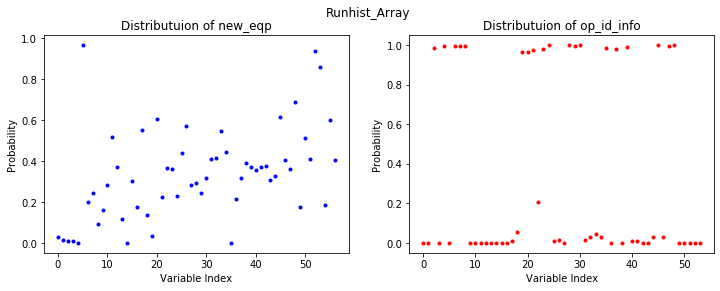

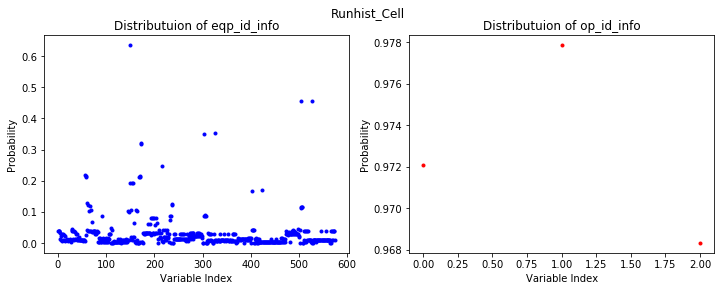

In [41]:
# array = runhist_array_f(runhist_array, id_mapping)
variable = runhist.iloc[:,1:].drop(columns = 'GB').apply(np.mean, axis = 0)
eqp1 = variable[:57]
op1 = variable[57:111]
eqp2 = variable[111:686]
op2 = variable[686:]

fig, axs = plt.subplots(1, 2, figsize = (12, 4))
fig.suptitle('Runhist_Array')
axs[0].plot(list(range(len(eqp1))), eqp1, 'b.')
axs[0].set_xlabel('Variable Index')
axs[0].set_ylabel('Probability')
axs[0].set_title('Distributuion of new_eqp')
axs[1].plot(list(range(len(op1))), op1, 'r.')
axs[1].set_xlabel('Variable Index')
axs[1].set_ylabel('Probability')
axs[1].set_title('Distributuion of op_id_info')

fig, axs = plt.subplots(1, 2, figsize = (12, 4))
fig.suptitle('Runhist_Cell')
axs[0].plot(list(range(len(eqp2))), eqp2, 'b.')
axs[0].set_xlabel('Variable Index')
axs[0].set_ylabel('Probability')
axs[0].set_title('Distributuion of eqp_id_info')
axs[1].plot(list(range(len(op2))), op2, 'r.')
axs[1].set_xlabel('Variable Index')
axs[1].set_ylabel('Probability')
axs[1].set_title('Distributuion of op_id_info')

In [13]:
run_bad_types = Bad_Type_def(runhist)
#run_bad_types.to_csv('run_bad_types.csv')

Number of Bad: 67
Types of Bad: 67 

